## Definições
Bibliotecas utilizadas e definições de path. Para facilitar a manipulação de arquivos, o diretório do projeto é definido neste ponto. Também é realizada a carga dos dados brutos, que serão processados para gerar o conjunto de dados interpretável que alimentará a modelagem.

In [43]:
import numpy as np
import pandas as pd
from typing import List, Tuple
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

base_path = "C:/Users/99818854/Projetos/GitRep/adaptive_learning"
#base_path = "/media/bruno/Arquivos/Desenvolvimento/NextQuestion"

In [2]:
base = pd.read_csv(f"{base_path}/data/mastery.csv")
submit = pd.read_csv(f"{base_path}/data/Submit.csv", sep=";")
mastery_params = [[4.44], [0.33], [0.86], [0.86], [0.46], [0.39]]

## Processamento
O processo de modelagem requer um recorte de dados que permita uma avaliação da capacidade de generalização do modelo criado. Neste ponto, é preciso garantir uma secção forte dos dados que serão utilizados no processo de treinamento e aqueles utilizados na avaliação. O cálculo da maestria representa um potencial risco de data leakage, já que por definição é uma série histórica. Porém, a abordagem trabalhada anteriormente permite contornar este problema, trabalhando com um pontuação relacionada com o total de acertos.

No caso da dificuldade, que apresenta valores vazios, a substituição deve ser feita no intuito de possibilitar o funcionamento do processo de treinamento, sem a necessidade de excluir estes registros. Também é tomado o cuidado para evitar vazamento, de modo que o valor utilizado como padrão é calculado exclusivamente na seção de treino.

Esta abordagem conta com dois inputs: maestria e dificuldade. Isso significa que, para o conjunto real de submissão, é preciso ter o rastreamento da maestria atual do usuário para uma determinada área de conhecimento. Ou seja, mesmo que a área não seja uma variável de entrada no modelo, ela representa uma variável de controle para a maestria. Para suprir essa necessidade, duas funções auxiliares foram criadas para permitir essa filtragem de informações do usuário. A estrutura de dados de árvore foi adotada no lugar de dataframes, tornando mais eficiente o processo de busca e acesso do valor para um dado usuário e dada área de conhecimento.

In [12]:
def get_data() -> Tuple[np.array, np.array, np.array, np.array, float]:
    mastery = np.dot(base.values[:, 3:-1], mastery_params)
    X, y = np.concatenate((base.values[:, 2:3], mastery), axis=1), base.values[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    mean_difficulty = round(np.nanmean(X_train[:, 0]))
    X_train[np.isnan(X_train)] = mean_difficulty
    X_test[np.isnan(X_test)] = mean_difficulty

    return X_train, X_test, y_train, y_test, mean_difficulty


def get_mastery_by_user() -> dict:
    user_data = {}
    group = base.groupby(["user_id", "area"])[[
        "points", "points1", "points2", "points3", "points4", "points5"
    ]].agg("max")

    for i in range(0, len(group)):
        user_id, area = group.index[i]
        if user_id not in user_data.keys():
            user_data[user_id] = {}
        user_data[user_id][area] = np.dot(group.values[i], mastery_params)[0]

    return user_data


def search_mastery(user_data: dict, user_id: int, area: int) -> float:
    if user_id not in user_data.keys():
        return 0
    if area not in user_data[user_id].keys():
        return 0
    return user_data[user_id][area]

## Treinamento
Por se tratar de uma abordagem minimalista, baseado no conceito de maestria, não se faz necessário teste de modelos de alta complexidade e baixa interpretabilidade. Por isso, dois modelos foram testados, no objetivo de encontrar uma intepretação razoável do problema. Importante comentar que para o modelo linear é necessário a padronização dos dados de entrada, uma vez que a maestria pode assumir qualquer valor maior ou igual a 0. Para a árvore de decisão não existe influência da escala.

Do modelo linear é particularmente interessante avaliar o resultado dos coeficientes, que ilustram bastante a dinâmica encontrada pelo modelo. Seguindo a proposta teórica, a maestria contribui com a probabilidade de acerto (sinal positivo), enquanto a dificuldade gera o efeito contrário (sinal negativo). Quanto maior a dificuldade, menor a probabilidade de conseguir um acerto. Considerando que a dificuldade possui um limite, em um determinado momento a maestria acumulada vai ser capaz de suprimir esse efeito da dificuldade e a probabilidade de acerto aumenta. Dessa forma, o modelo linear contribui para uma forte interpretação da dinâmica da probabilidade de acerto de forma numérica.

O uso de árvore de decisão parte da ideia de ter um modelo fortemente explicável. Infelizmente, utilizando uma profundidade máxima de 5 ou 10 (para ter árvores mais curtas), as métricas não superam o modelo linear, de modo que a interpretabilidade fica prejudicada quando se preza pelas métricas. Todavia, ainda é interessante comentar sobre o resultado da árvore curta. Uma observação é que a dificuldade aparece frequentemente nos nós superiores e a maestria nos nós inferiores. Ou seja, primeiro ocorre o corte na dificuldade, depois da maestria, uma lógica que se aproxima com os estudos teóricos. Assim, mesmo que encontremos uma árvore altamente complexa para potencializar as métricas, podemos esperar que a lógica não seria abstrata ou particular em excesso.

In [27]:
def train_linear() -> Tuple[SGDClassifier, StandardScaler, float]:
    X_train, X_test, y_train, y_test, mean_difficulty = get_data()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = SGDClassifier(loss="log", learning_rate="adaptive", eta0=0.001)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    print("MODELO LINEAR")
    print(f"Coeficientes: {model.coef_[0][0]} (Dificuldade) e {model.coef_[0][1]} (Maestria)")
    print(f"Acurácia: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    return model, scaler, mean_difficulty


linear_model, linear_scaler, linear_mean_difficulty = train_linear()

MODELO LINEAR
Coeficientes: -0.6963799192395294 (Dificuldade) e 0.23336113747981127 (Maestria)
Acurácia: 0.6843883333333334
Precision: 0.7155869672228541
Recall: 0.8590813106085113
F1-score: 0.7807960550304729


In [42]:
def train_tree(deep: int=None) -> DecisionTreeClassifier:
    X_train, X_test, y_train, y_test, mean_difficulty = get_data()
    model = DecisionTreeClassifier(criterion="entropy", splitter="random", max_depth=deep)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    print("MODELO ÁRVORE DE DECISÃO")
    print(f"Acurácia: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    return model, mean_difficulty


tree_model, tree_mean_difficulty = train_tree()

MODELO ÁRVORE DE DECISÃO
Acurácia: 0.713395
Precision: 0.7268215965622234
Recall: 0.9009732409636715
F1-score: 0.8045815042052425


MODELO ÁRVORE DE DECISÃO
Acurácia: 0.6849833333333334
Precision: 0.7104165720443782
Recall: 0.8759310074480596
F1-score: 0.7845391661992895


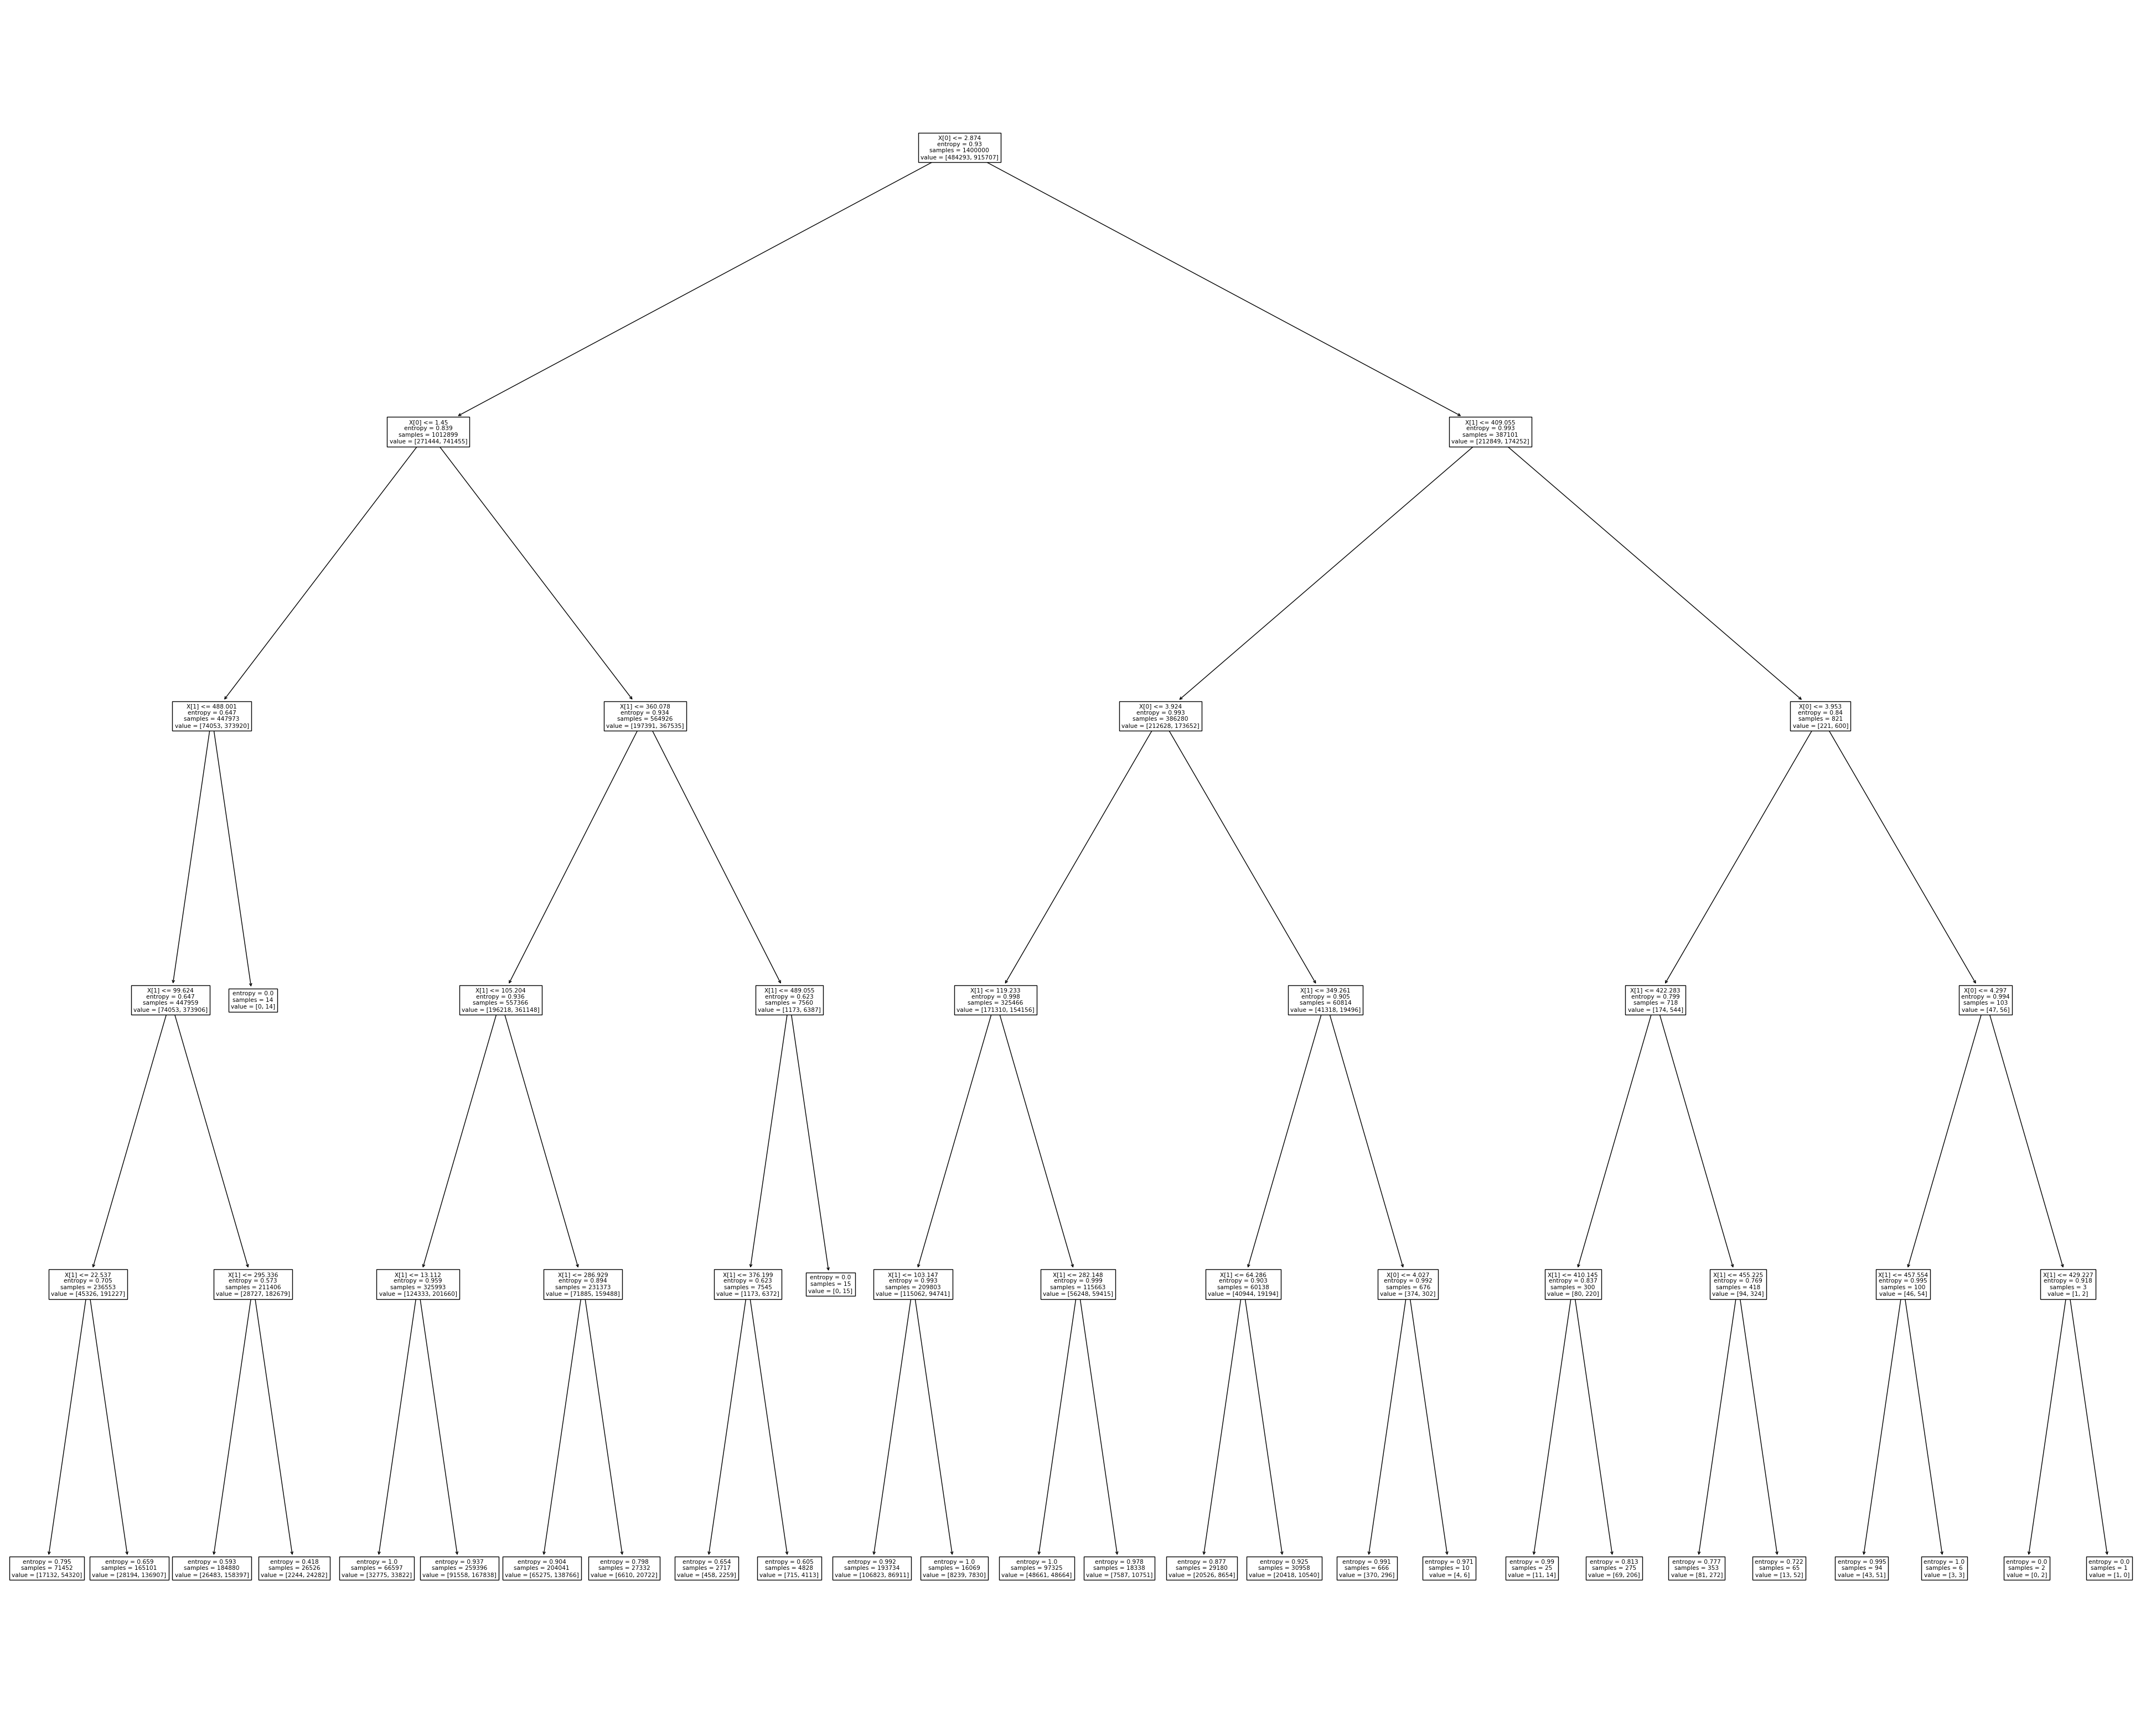

In [44]:
def show_tree() -> None:
    model, _ = train_tree(deep=5)
    plt.figure(figsize=(50, 40))
    plot_tree(model)
    plt.show()


show_tree()

## Geração de previsão
O trabalho com o conjunto de submissão requer um processamento um pouco diferente. O primeiro é a busca história da maestria atual de cada usuário, processo executado pelas funções definidas na seção Processamento. O próximo passo, como já comentado anteriormente, é a substituição dos valores vazios da dificuldade, que é uma importante variável para funcionamento do modelo. O valor padrão utilizado para substituição é o encontrado no processo de treinamento.

Com esta etapa, finaliza-se o processo de treino, gerando o arquivo que será utilizado para fornecer o resultado final do processo executado neste repositório.

In [41]:
def generate_predict_tree() -> None:
    df = submit[["difficulty", "novo_user_id", "knowledge_area_id"]]
    df = df.fillna(tree_mean_difficulty)

    user_data = get_mastery_by_user()
    df["mastery"] = [search_mastery(user_data, df["novo_user_id"].values[i], df["knowledge_area_id"].values[i]) for i in range(0, len(df))]

    df["predict"] = tree_model.predict(df[["difficulty", "mastery"]].values)
    print(df.groupby("predict")["predict"].count())
    pd.DataFrame(df["predict"].values, columns=["acertou"]).to_csv(f"{base_path}/data/result.csv", index=False)


generate_predict_tree()

predict
0.0     3571
1.0    16429
Name: predict, dtype: int64
